## backbone out

In [1]:
import torch
from torch import nn
from einops import rearrange


S3 = torch.rand(size=(2, 512, 80, 80))
S4 = torch.rand(size=(2, 1024, 40, 40))
S5 = torch.rand(size=(2, 2048, 20, 20))

feats = [S3, S4, S5]

for i in feats:
    print(i.shape)


torch.Size([2, 512, 80, 80])
torch.Size([2, 1024, 40, 40])
torch.Size([2, 2048, 20, 20])


## AIFI

In [2]:
def get_activation(act: str, inpace: bool=True):
    '''get activation
    '''
    act = act.lower()
    
    if act == 'silu':
        m = nn.SiLU()

    elif act == 'relu':
        m = nn.ReLU()

    elif act == 'leaky_relu':
        m = nn.LeakyReLU()

    elif act == 'silu':
        m = nn.SiLU()
    
    elif act == 'gelu':
        m = nn.GELU()
        
    elif act is None:
        m = nn.Identity()
    
    elif isinstance(act, nn.Module):
        m = act

    else:
        raise RuntimeError('')  

    if hasattr(m, 'inplace'):
        m.inplace = inpace
    
    return m 

In [3]:
import copy

# transformer
class TransformerEncoderLayer(nn.Module):
    def __init__(self,
                 d_model,
                 nhead,
                 dim_feedforward=2048,
                 dropout=0.1,
                 activation="relu",
                 normalize_before=False):
        super().__init__()
        self.normalize_before = normalize_before

        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout, batch_first=True)

        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = get_activation(activation) 

    @staticmethod
    def with_pos_embed(tensor, pos_embed):
        return tensor if pos_embed is None else tensor + pos_embed

    def forward(self, src, src_mask=None, pos_embed=None) -> torch.Tensor:
        residual = src
        if self.normalize_before:
            src = self.norm1(src)
        q = k = self.with_pos_embed(src, pos_embed)
        src, _ = self.self_attn(q, k, value=src, attn_mask=src_mask)

        src = residual + self.dropout1(src)
        if not self.normalize_before:
            src = self.norm1(src)

        residual = src
        if self.normalize_before:
            src = self.norm2(src)
        src = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = residual + self.dropout2(src)
        if not self.normalize_before:
            src = self.norm2(src)
        return src


class TransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers, norm=None):
        super(TransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer) for _ in range(num_layers)])
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src, src_mask=None, pos_embed=None) -> torch.Tensor:
        output = src
        for layer in self.layers:
            output = layer(output, src_mask=src_mask, pos_embed=pos_embed)

        if self.norm is not None:
            output = self.norm(output)

        return output

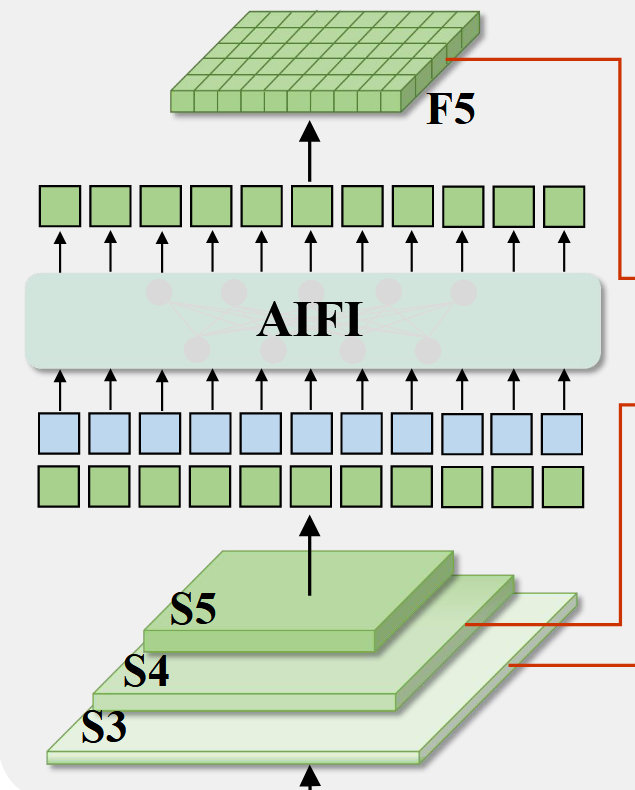

In [4]:
import copy

class AIFI(nn.Module):
    def __init__(self, 
                 in_channels = [512, 1024, 2048],
                 feat_strides=[8, 16, 32],
                 hidden_dim = 256,
                 nhead = 8,
                 dim_feedforward = 1024,
                 dropout = 0.0,
                 enc_act = 'gelu',
                 use_encoder_idx = [2],
                 num_encoder_layers = 1,
                 pe_temperature=10000,
                 eval_spatial_size = None
            ):
        super().__init__()
        
        self.in_channels = in_channels
        self.feat_strides = feat_strides
        self.hidden_dim = hidden_dim
        self.use_encoder_idx = use_encoder_idx
        self.num_encoder_layers = num_encoder_layers
        self.pe_temperature = pe_temperature
        self.eval_spatial_size = eval_spatial_size
        
        self.out_channels = [hidden_dim for _ in range(len(in_channels))]
        self.out_strides = feat_strides
        
        
        # channel uniform
        self.input_proj = nn.ModuleList()
        for in_channel in in_channels:
            self.input_proj.append(
                nn.Sequential(
                    nn.Conv2d(in_channel, hidden_dim, kernel_size=1, bias=False),
                    nn.BatchNorm2d(hidden_dim)
                )
            )
        
        # encoder transformer
        encoder_layer = TransformerEncoderLayer(
            hidden_dim, 
            nhead=nhead,
            dim_feedforward=dim_feedforward, 
            dropout=dropout,
            activation=enc_act)

        self.encoder = nn.ModuleList([
            TransformerEncoder(copy.deepcopy(encoder_layer), num_encoder_layers) for _ in range(len(use_encoder_idx))
        ])
        
        self._reset_parameters()


    def _reset_parameters(self):
        if self.eval_spatial_size:
            for idx in self.use_encoder_idx:
                stride = self.feat_strides[idx]
                pos_embed = self.build_2d_sincos_position_embedding(
                    self.eval_spatial_size[1] // stride, self.eval_spatial_size[0] // stride,
                    self.hidden_dim, self.pe_temperature)
                setattr(self, f'pos_embed{idx}', pos_embed)
                # self.register_buffer(f'pos_embed{idx}', pos_embed)
                
    
    @staticmethod
    def build_2d_sincos_position_embedding(w, h, embed_dim=256, temperature=10000.):
        '''
        '''
        grid_w = torch.arange(int(w), dtype=torch.float32)
        grid_h = torch.arange(int(h), dtype=torch.float32)
        grid_w, grid_h = torch.meshgrid(grid_w, grid_h, indexing='ij')
        assert embed_dim % 4 == 0, \
            'Embed dimension must be divisible by 4 for 2D sin-cos position embedding'
        pos_dim = embed_dim // 4
        omega = torch.arange(pos_dim, dtype=torch.float32) / pos_dim
        omega = 1. / (temperature ** omega)

        out_w = grid_w.flatten()[..., None] @ omega[None]
        out_h = grid_h.flatten()[..., None] @ omega[None]

        return torch.concat([out_w.sin(), out_w.cos(), out_h.sin(), out_h.cos()], dim=1)[None, :, :]
    
    
    def forward(self, feats):
        assert len(feats) == len(self.in_channels)
        proj_feats = [self.input_proj[i](feat) for i, feat in enumerate(feats)]
        
        # AIFI
        if self.num_encoder_layers > 0:
            for i, enc_ind in enumerate(self.use_encoder_idx):
                h, w = proj_feats[enc_ind].shape[2: ]
                # flatten [B, C, H, W] to [B, HxW, C]
                src_flatten = proj_feats[enc_ind].flatten(2).permute(0, 2, 1)
                if self.training or self.eval_spatial_size is None:
                    pos_embed = self.build_2d_sincos_position_embedding(
                        w, h, self.hidden_dim, self.pe_temperature).to(src_flatten.device)
                else:
                    pos_embed = getattr(self, f'pos_embed{enc_ind}', None).to(src_flatten.device)

                memory = self.encoder[i](src_flatten, pos_embed=pos_embed)
                proj_feats[enc_ind] = memory.permute(0, 2, 1).reshape(-1, self.hidden_dim, h, w).contiguous()
                # print([x.is_contiguous() for x in proj_feats ])
        
        return proj_feats
    

In [5]:
test_AIFI_model = AIFI()
AIFI_output_feats = test_AIFI_model(feats)
for i in AIFI_output_feats:
    print(i.shape)

torch.Size([2, 256, 80, 80])
torch.Size([2, 256, 40, 40])
torch.Size([2, 256, 20, 20])


## CCFF

In [6]:
class ConvNormLayer(nn.Module):
    def __init__(self, ch_in, ch_out, kernel_size, stride, padding=None, bias=False, act=None):
        super().__init__()
        self.conv = nn.Conv2d(
            ch_in, 
            ch_out, 
            kernel_size, 
            stride, 
            padding=(kernel_size-1)//2 if padding is None else padding, 
            bias=bias)
        self.norm = nn.BatchNorm2d(ch_out)
        self.act = nn.Identity() if act is None else get_activation(act) 

    def forward(self, x):
        return self.act(self.norm(self.conv(x)))
    

class RepVggBlock(nn.Module):
    def __init__(self, ch_in, ch_out, act='relu'):
        super().__init__()
        self.ch_in = ch_in
        self.ch_out = ch_out
        self.conv1 = ConvNormLayer(ch_in, ch_out, 3, 1, padding=1, act=None)
        self.conv2 = ConvNormLayer(ch_in, ch_out, 1, 1, padding=0, act=None)
        self.act = nn.Identity() if act is None else get_activation(act) 

    def forward(self, x):
        if hasattr(self, 'conv'):
            y = self.conv(x)
        else:
            y = self.conv1(x) + self.conv2(x)

        return self.act(y)

    def convert_to_deploy(self):
        if not hasattr(self, 'conv'):
            self.conv = nn.Conv2d(self.ch_in, self.ch_out, 3, 1, padding=1)

        kernel, bias = self.get_equivalent_kernel_bias()
        self.conv.weight.data = kernel
        self.conv.bias.data = bias 
        # self.__delattr__('conv1')
        # self.__delattr__('conv2')

    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.conv1)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.conv2)
        
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1), bias3x3 + bias1x1

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return F.pad(kernel1x1, [1, 1, 1, 1])

    def _fuse_bn_tensor(self, branch: ConvNormLayer):
        if branch is None:
            return 0, 0
        kernel = branch.conv.weight
        running_mean = branch.norm.running_mean
        running_var = branch.norm.running_var
        gamma = branch.norm.weight
        beta = branch.norm.bias
        eps = branch.norm.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std
    

class CSPRepLayer(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 num_blocks=3,
                 expansion=1.0,
                 bias=None,
                 act="silu"):
        super(CSPRepLayer, self).__init__()
        hidden_channels = int(out_channels * expansion)
        self.conv1 = ConvNormLayer(in_channels, hidden_channels, 1, 1, bias=bias, act=act)
        self.conv2 = ConvNormLayer(in_channels, hidden_channels, 1, 1, bias=bias, act=act)
        self.bottlenecks = nn.Sequential(*[
            RepVggBlock(hidden_channels, hidden_channels, act=act) for _ in range(num_blocks)
        ])
        if hidden_channels != out_channels:
            self.conv3 = ConvNormLayer(hidden_channels, out_channels, 1, 1, bias=bias, act=act)
        else:
            self.conv3 = nn.Identity()

    def forward(self, x):
        x_1 = self.conv1(x)
        x_1 = self.bottlenecks(x_1)
        x_2 = self.conv2(x)
        return self.conv3(x_1 + x_2)

### TOP - down  (fusion)

In [7]:
import torch.nn.functional as F

class CCFF_top_down(nn.Module):
    def __init__(self, 
                 in_channels = [512, 1024, 2048],
                 feat_strides = [8, 16, 32],
                 hidden_dim = 256,
                 expansion=1.0,
                 depth_mult=1.0,
                 act = 'silu',
                 ):
        super().__init__()
        
        self.in_channels = in_channels
        self.hidden_dim = hidden_dim

        # top-down fpn
        self.lateral_convs = nn.ModuleList()
        self.fpn_blocks = nn.ModuleList()
        
        for _ in range(len(in_channels) - 1, 0, -1):
            self.lateral_convs.append(ConvNormLayer(hidden_dim, hidden_dim, 1, 1, act=act))
            self.fpn_blocks.append(
                CSPRepLayer(hidden_dim * 2, hidden_dim, round(3 * depth_mult), act=act, expansion=expansion)
            )
    
    
    def forward(self, feats):
        assert len(feats) == len(self.in_channels)
        
        # broadcasting and fusion
        inner_outs = [feats[-1]]
        for idx in range(len(self.in_channels) - 1, 0, -1):
            feat_high = inner_outs[0]   # idx = 2 (bs, 256, 20, 20)     idx = 1 (bs, 256, 40, 40)
            feat_low = feats[idx - 1]   # idx = 2 (bs, 256, 40, 40)     idx = 1 (bs 256, 80, 80)
            
            feat_high = self.lateral_convs[len(self.in_channels) - 1 - idx](feat_high)
            inner_outs[0] = feat_high
            upsample_feat = F.interpolate(feat_high, scale_factor=2, mode='nearest')
            
            inner_out = self.fpn_blocks[len(self.in_channels) - 1 - idx](torch.concat([upsample_feat, feat_low], dim=1))
            inner_outs.insert(0, inner_out)     # 将 inner_out 插入到索引为0的位置
        
        return inner_outs

In [8]:
CCFF_top_down_model = CCFF_top_down()
top_down_outputs = CCFF_top_down_model(AIFI_output_feats)

for i in top_down_outputs:
    print(i.shape)

torch.Size([2, 256, 80, 80])
torch.Size([2, 256, 40, 40])
torch.Size([2, 256, 20, 20])


### downsample

In [9]:
class CCFF_downsample(nn.Module):
    def __init__(self, 
                 in_channels = [512, 1024, 2048],
                 hidden_dim = 256,
                 act = 'silu',
                 expansion=1.0,
                 depth_mult=1.0,
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_dim = hidden_dim
        
        # bottom-up pan
        self.downsample_convs = nn.ModuleList()
        self.pan_blocks = nn.ModuleList()
        
        for _ in range(len(in_channels) - 1):
            self.downsample_convs.append(
                ConvNormLayer(hidden_dim, hidden_dim, kernel_size=3, stride=2, act=act)
            )
            self.pan_blocks.append(
                CSPRepLayer(hidden_dim * 2, hidden_dim, round(3 * depth_mult), act=act, expansion=expansion)
            )
        
        
    def forward(self, inner_outs):
        
        outs = [inner_outs[0]]
        for idx in range(len(self.in_channels) - 1):
            feat_low = outs[-1]
            feat_high = inner_outs[idx + 1]
            downsample_feat = self.downsample_convs[idx](feat_low)
            out = self.pan_blocks[idx](torch.concat([downsample_feat, feat_high], dim=1))
            outs.append(out)
            
        return outs


In [10]:
CCFF_downsample_test_model = CCFF_downsample()
downsample_output = CCFF_downsample_test_model(top_down_outputs)

for i in downsample_output:
    print(i.shape)

torch.Size([2, 256, 80, 80])
torch.Size([2, 256, 40, 40])
torch.Size([2, 256, 20, 20])


## Decoder

In [12]:
def deformable_attention_core_func(value, value_spatial_shapes, sampling_locations, attention_weights):
    """
    Args:
        value (Tensor): 
                        [bs, c, h, w] -> [bs, (h w), c] -> (bs, value_length, n_head, c // n_head)
                        [bs, value_length, n_head, c]
        value_spatial_shapes (Tensor|List): [n_levels, 2]   like: [[80, 80], [40, 40], [20, 20]]
        value_level_start_index (Tensor|List): [n_levels]
        sampling_locations (Tensor): [bs, query_length, n_head, n_levels, n_points, 2]
        attention_weights (Tensor): [bs, query_length, n_head, n_levels, n_points]

    Returns:
        output (Tensor): [bs, Length_{query}, C]
    """
    bs, _, n_head, c = value.shape
    _, Len_q, _, n_levels, n_points, _ = sampling_locations.shape
    
    split_shape = [h * w for h, w in value_spatial_shapes]
    value_list = value.split(split_shape, dim=1)         # value_list[0]: [bs, 6400, n_head, c], value_list[1]: [bs, 1600, n_head, c] ...
    sampling_grids = 2 * sampling_locations - 1          # from (0, 1) locations to (-1, 1)
    sampling_value_list = []
    
    
    for level, (h, w) in enumerate(value_spatial_shapes):
        # N_, (H_*W_), M_, D_ -> N_, (H_*W_), (M_*D_) -> N_, M_*D_, H_*W_ -> N_*M_, D_, H_, W_
        # back to [N, C, H_in, W_in] (N = bs * n_head, C = c, H_in = h, W_in = w)
        value_l_ = value_list[level].flatten(2).permute(0, 2, 1).reshape(bs*n_head, c, h, w)
        
        # N_, Lq_, M_, P_, 2 -> N_, M_, Lq_, P_, 2 -> N_*M_, Lq_, P_, 2
        # to [N, H_out, W_out, 2], (N = bs * n_head, H_out = Len_q, W_out = n_points)
        sampling_grid_l_ = sampling_grids[:, :, :, level].permute(0, 2, 1, 3, 4).flatten(0, 1)
        
        # N_*M_, D_, Lq_, P_
        sampling_value_l_ = F.grid_sample(
            value_l_,
            sampling_grid_l_,
            mode='bilinear',
            padding_mode='zeros',
            align_corners=False
        )
        
        sampling_value_list.append(sampling_value_l_)
    
     # (N_, Lq_, M_, L_, P_) -> (N_, M_, Lq_, L_, P_) -> (N_*M_, 1, Lq_, L_*P_)
    attention_weights = attention_weights.permute(0, 2, 1, 3, 4).reshape(bs * n_head, 1, Len_q, n_levels * n_points)
    output = (torch.stack(
        sampling_value_list, dim=-2).flatten(-2) *
              attention_weights).sum(-1).reshape(bs, n_head * c, Len_q)

    return output.permute(0, 2, 1)
    

### box ops

In [13]:
'''
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
https://github.com/facebookresearch/detr/blob/main/util/box_ops.py
'''

import torch
from torchvision.ops.boxes import box_area

def inverse_sigmoid(x: torch.Tensor, eps: float=1e-5) -> torch.Tensor:
    x = x.clip(min=0., max=1.)
    return torch.log(x.clip(min=eps) / (1 - x).clip(min=eps))

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)


def box_xyxy_to_cxcywh(x):
    x0, y0, x1, y1 = x.unbind(-1)
    b = [(x0 + x1) / 2, (y0 + y1) / 2,
         (x1 - x0), (y1 - y0)]
    return torch.stack(b, dim=-1)


# modified from torchvision to also return the union
def box_iou(boxes1, boxes2):
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

    union = area1[:, None] + area2 - inter

    iou = inter / union
    return iou, union


def generalized_box_iou(boxes1, boxes2):
    """
    Generalized IoU from https://giou.stanford.edu/

    The boxes should be in [x0, y0, x1, y1] format

    Returns a [N, M] pairwise matrix, where N = len(boxes1)
    and M = len(boxes2)
    """
    # degenerate boxes gives inf / nan results
    # so do an early check
    assert (boxes1[:, 2:] >= boxes1[:, :2]).all()
    assert (boxes2[:, 2:] >= boxes2[:, :2]).all()
    iou, union = box_iou(boxes1, boxes2)

    lt = torch.min(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])

    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    area = wh[:, :, 0] * wh[:, :, 1]

    return iou - (area - union) / area


def masks_to_boxes(masks):
    """Compute the bounding boxes around the provided masks

    The masks should be in format [N, H, W] where N is the number of masks, (H, W) are the spatial dimensions.

    Returns a [N, 4] tensors, with the boxes in xyxy format
    """
    if masks.numel() == 0:
        return torch.zeros((0, 4), device=masks.device)

    h, w = masks.shape[-2:]

    y = torch.arange(0, h, dtype=torch.float)
    x = torch.arange(0, w, dtype=torch.float)
    y, x = torch.meshgrid(y, x)

    x_mask = (masks * x.unsqueeze(0))
    x_max = x_mask.flatten(1).max(-1)[0]
    x_min = x_mask.masked_fill(~(masks.bool()), 1e8).flatten(1).min(-1)[0]

    y_mask = (masks * y.unsqueeze(0))
    y_max = y_mask.flatten(1).max(-1)[0]
    y_min = y_mask.masked_fill(~(masks.bool()), 1e8).flatten(1).min(-1)[0]

    return torch.stack([x_min, y_min, x_max, y_max], 1)

## denoising

In [14]:
sim_target = [
    {
        'labels': torch.tensor([3, 0, 0, 1]),
        'boxes': torch.tensor([
            [0.4113, 0.7784, 0.3679, 0.4433],
            [0.6646, 0.9303, 0.0822, 0.1371],
            [0.1509, 0.7139, 0.0535, 0.2653],
            [0.1712, 0.6474, 0.0269, 0.0747],
        ])
    },
    {
        'labels': torch.tensor([0, 77]),
        'boxes': torch.tensor([
            [0.4982, 0.3783, 0.0425, 0.0107],
            [0.6783, 0.4064, 0.0088, 0.0426],
        ])
    }
]

num_gts = [len(t['labels']) for t in sim_target]

max_gt_num = max(num_gts)
if max_gt_num == 0:
    print("None, None, None, None")

num_denoising = 100
# num_group = num_denoising // max_gt_num
num_group = 2
print(f'num_group = {num_group}')

bs = len(num_gts)

input_query_class = torch.full([bs, max_gt_num], 80, dtype=torch.int32)
input_query_bbox = torch.zeros([bs, max_gt_num, 4])
pad_gt_mask = torch.zeros([bs, max_gt_num], dtype=torch.bool)

print('before: \n--------------------------------')
print(f'input_query_class:\n{input_query_class}')
# print(f'input_query_bbox:\n{input_query_bbox}')
print(f'pad_gt_mask: \n{pad_gt_mask}')

for i in range(bs):
    num_gt = num_gts[i]
    if num_gt > 0:
        input_query_class[i, :num_gt] = sim_target[i]['labels']
        input_query_bbox[i, :num_gt] = sim_target[i]['boxes']
        pad_gt_mask[i, :num_gt] = 1

print('\nafter: \n--------------------------------')
print(f'input_query_class:\n{input_query_class}')
# print(f'input_query_bbox:\n{input_query_bbox}')
print(f'pad_gt_mask: \n{pad_gt_mask}')

# each group has positive and negative queries, for 2 * num_group
input_query_class = input_query_class.tile([1, 2 * num_group])
input_query_bbox = input_query_bbox.tile([1, 2*num_group, 1])
pad_gt_mask = pad_gt_mask.tile([1, 2 * num_group])

print('\nafter tile: \n--------------------------------')
print(f'input_query_class:\n{input_query_class}')
# print(f'input_query_bbox:\n{input_query_bbox}')
print(f'pad_gt_mask: \n{pad_gt_mask}')

# positive and negative mask
negative_gt_mask = torch.zeros([bs, max_gt_num * 2, 1])
negative_gt_mask[:, max_gt_num:] = 1
negative_gt_mask = negative_gt_mask.tile([1, num_group, 1])

positive_gt_mask = 1 - negative_gt_mask
positive_gt_mask = positive_gt_mask.squeeze(-1) * pad_gt_mask

print(f'\nnegative_gt_mask: (for convenience not ture ng_mask)\n {negative_gt_mask.squeeze(-1)}')
print(f'\npositive_gt_mask: \n {positive_gt_mask}')

dn_positive_idx = torch.nonzero(positive_gt_mask)[:, 1]
dn_positive_idx = torch.split(dn_positive_idx, [n * num_group for n in num_gts] )
print(f'\n dn_positive_idx: \n{dn_positive_idx}')

# total denoising queries
num_denoising = int(max_gt_num * 2 * num_group)
print(f'\nnum_denoising(max_gt_num * 2 * num_group) = 4 x 2 x 2 = {num_denoising}')

label_noise_ratio = 0.5
box_noise_scale = 1.0

if label_noise_ratio > 0:
    mask = torch.rand_like(input_query_class, dtype=torch.float)
    print(f'mask (before < label_noise_ratio * 0.5): {mask}')
    mask = mask < (label_noise_ratio * 0.5)
    print(f'mask (after < label_noise_ratio * 0.5): {mask}')
    
    # randomly put a new one here
    new_label = torch.randint_like(mask, 0, 80, dtype=input_query_class.dtype)
    print(f'random generate noise label: \n{new_label}')
    input_query_class = torch.where(mask & pad_gt_mask, new_label, input_query_class)
    print(f'noisy input_query_class: \n{input_query_class}')
    
# GT 边界框添加随机的偏移/缩放 (独立于标签噪声)
if box_noise_scale > 0:
        known_bbox = box_cxcywh_to_xyxy(input_query_bbox)
        diff = torch.tile(input_query_bbox[..., 2:] * 0.5, [1, 1, 2]) * box_noise_scale
        rand_sign = torch.randint_like(input_query_bbox, 0, 2) * 2.0 - 1.0
        rand_part = torch.rand_like(input_query_bbox)
        rand_part = (rand_part + 1.0) * negative_gt_mask + rand_part * (1 - negative_gt_mask)
        rand_part *= rand_sign
        known_bbox += rand_part * diff
        known_bbox.clip_(min=0.0, max=1.0)
        input_query_bbox = box_xyxy_to_cxcywh(known_bbox)
        input_query_bbox = inverse_sigmoid(input_query_bbox)

num_classes = 80
hidden_dim = 256
num_queries = 100

denoising_class_embed = nn.Embedding(num_classes+1, hidden_dim, padding_idx=num_classes)

input_query_class = denoising_class_embed(input_query_class)
print(f'\nafter class_embed input_query_class: {input_query_class.shape}')

tgt_size = num_denoising + num_queries
print(f'tgt_size: {tgt_size}')

attn_mask = torch.full([tgt_size, tgt_size], False, dtype=torch.bool)
print(f'\n before match query: attn_mask = \n{attn_mask}, shape: {attn_mask.shape}')

# 在多头注意力中掩码值为True表示禁止注意力，防止标准查询看到去噪查询中包含的GT信息, 在左下角画出100x16的True, 表示标准查询不应该涉及到去噪查询
attn_mask[num_denoising:, :num_denoising] = True
print(f'\n after match query: attn_mask = \n{attn_mask}, shape: {attn_mask.shape}')

# reconstruct cannot see each other     # 只让去噪查询区域的块主对角线上生效
for i in range(num_group):
    if i == 0:
        attn_mask[max_gt_num * 2 * i: max_gt_num * 2 * (i + 1), max_gt_num * 2 * (i + 1): num_denoising] = True
    if i == num_group - 1:
        attn_mask[max_gt_num * 2 * i: max_gt_num * 2 * (i + 1), :max_gt_num * i * 2] = True
    else:
        attn_mask[max_gt_num * 2 * i: max_gt_num * 2 * (i + 1), max_gt_num * 2 * (i + 1): num_denoising] = True
        attn_mask[max_gt_num * 2 * i: max_gt_num * 2 * (i + 1), :max_gt_num * 2 * i] = True

print(attn_mask)
    

num_group = 2
before: 
--------------------------------
input_query_class:
tensor([[80, 80, 80, 80],
        [80, 80, 80, 80]], dtype=torch.int32)
pad_gt_mask: 
tensor([[False, False, False, False],
        [False, False, False, False]])

after: 
--------------------------------
input_query_class:
tensor([[ 3,  0,  0,  1],
        [ 0, 77, 80, 80]], dtype=torch.int32)
pad_gt_mask: 
tensor([[ True,  True,  True,  True],
        [ True,  True, False, False]])

after tile: 
--------------------------------
input_query_class:
tensor([[ 3,  0,  0,  1,  3,  0,  0,  1,  3,  0,  0,  1,  3,  0,  0,  1],
        [ 0, 77, 80, 80,  0, 77, 80, 80,  0, 77, 80, 80,  0, 77, 80, 80]],
       dtype=torch.int32)
pad_gt_mask: 
tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [ True,  True, False, False,  True,  True, False, False,  True,  True,
         False, False,  True,  True, False, False]])

negative_gt_mask: (

In [21]:
def get_contrastive_denoising_training_group(targets,
                                             num_classes,
                                             num_queries,
                                             class_embed,
                                             num_denoising=100,
                                             label_noise_ratio=0.5,
                                             box_noise_scale=1.0,):
    """cnd"""
    if num_denoising <= 0:
        return None, None, None, None

    num_gts = [len(t['labels']) for t in targets]
    device = targets[0]['labels'].device
    
    max_gt_num = max(num_gts)
    if max_gt_num == 0:
        return None, None, None, None

    num_group = num_denoising // max_gt_num
    num_group = 1 if num_group == 0 else num_group
    # pad gt to max_num of a batch
    bs = len(num_gts)

    input_query_class = torch.full([bs, max_gt_num], num_classes, dtype=torch.int32, device=device)
    input_query_bbox = torch.zeros([bs, max_gt_num, 4], device=device)
    pad_gt_mask = torch.zeros([bs, max_gt_num], dtype=torch.bool, device=device)

    for i in range(bs):
        num_gt = num_gts[i]
        if num_gt > 0:
            input_query_class[i, :num_gt] = targets[i]['labels']
            input_query_bbox[i, :num_gt] = targets[i]['boxes']
            pad_gt_mask[i, :num_gt] = 1
    # each group has positive and negative queries.
    input_query_class = input_query_class.tile([1, 2 * num_group])
    input_query_bbox = input_query_bbox.tile([1, 2 * num_group, 1])
    pad_gt_mask = pad_gt_mask.tile([1, 2 * num_group])
    # positive and negative mask
    negative_gt_mask = torch.zeros([bs, max_gt_num * 2, 1], device=device)
    negative_gt_mask[:, max_gt_num:] = 1
    negative_gt_mask = negative_gt_mask.tile([1, num_group, 1])
    positive_gt_mask = 1 - negative_gt_mask
    # contrastive denoising training positive index
    positive_gt_mask = positive_gt_mask.squeeze(-1) * pad_gt_mask
    dn_positive_idx = torch.nonzero(positive_gt_mask)[:, 1]
    dn_positive_idx = torch.split(dn_positive_idx, [n * num_group for n in num_gts])
    # total denoising queries
    num_denoising = int(max_gt_num * 2 * num_group)

    if label_noise_ratio > 0:
        mask = torch.rand_like(input_query_class, dtype=torch.float) < (label_noise_ratio * 0.5)
        # randomly put a new one here
        new_label = torch.randint_like(mask, 0, num_classes, dtype=input_query_class.dtype)
        input_query_class = torch.where(mask & pad_gt_mask, new_label, input_query_class)

    # if label_noise_ratio > 0:
    #     input_query_class = input_query_class.flatten()
    #     pad_gt_mask = pad_gt_mask.flatten()
    #     # half of bbox prob
    #     # mask = torch.rand(input_query_class.shape, device=device) < (label_noise_ratio * 0.5)
    #     mask = torch.rand_like(input_query_class) < (label_noise_ratio * 0.5)
    #     chosen_idx = torch.nonzero(mask * pad_gt_mask).squeeze(-1)
    #     # randomly put a new one here
    #     new_label = torch.randint_like(chosen_idx, 0, num_classes, dtype=input_query_class.dtype)
    #     # input_query_class.scatter_(dim=0, index=chosen_idx, value=new_label)
    #     input_query_class[chosen_idx] = new_label
    #     input_query_class = input_query_class.reshape(bs, num_denoising)
    #     pad_gt_mask = pad_gt_mask.reshape(bs, num_denoising)

    if box_noise_scale > 0:
        known_bbox = box_cxcywh_to_xyxy(input_query_bbox)
        diff = torch.tile(input_query_bbox[..., 2:] * 0.5, [1, 1, 2]) * box_noise_scale
        rand_sign = torch.randint_like(input_query_bbox, 0, 2) * 2.0 - 1.0
        rand_part = torch.rand_like(input_query_bbox)
        rand_part = (rand_part + 1.0) * negative_gt_mask + rand_part * (1 - negative_gt_mask)
        rand_part *= rand_sign
        known_bbox += rand_part * diff
        known_bbox.clip_(min=0.0, max=1.0)
        input_query_bbox = box_xyxy_to_cxcywh(known_bbox)
        input_query_bbox = inverse_sigmoid(input_query_bbox)

    # class_embed = torch.concat([class_embed, torch.zeros([1, class_embed.shape[-1]], device=device)])
    # input_query_class = torch.gather(
    #     class_embed, input_query_class.flatten(),
    #     axis=0).reshape(bs, num_denoising, -1)
    # input_query_class = class_embed(input_query_class.flatten()).reshape(bs, num_denoising, -1)
    input_query_class = class_embed(input_query_class)

    tgt_size = num_denoising + num_queries
    # attn_mask = torch.ones([tgt_size, tgt_size], device=device) < 0
    attn_mask = torch.full([tgt_size, tgt_size], False, dtype=torch.bool, device=device)
    # match query cannot see the reconstruction
    attn_mask[num_denoising:, :num_denoising] = True
    
    # reconstruct cannot see each other
    for i in range(num_group):
        if i == 0:
            attn_mask[max_gt_num * 2 * i: max_gt_num * 2 * (i + 1), max_gt_num * 2 * (i + 1): num_denoising] = True
        if i == num_group - 1:
            attn_mask[max_gt_num * 2 * i: max_gt_num * 2 * (i + 1), :max_gt_num * i * 2] = True
        else:
            attn_mask[max_gt_num * 2 * i: max_gt_num * 2 * (i + 1), max_gt_num * 2 * (i + 1): num_denoising] = True
            attn_mask[max_gt_num * 2 * i: max_gt_num * 2 * (i + 1), :max_gt_num * 2 * i] = True
        
    dn_meta = {
        "dn_positive_idx": dn_positive_idx,
        "dn_num_group": num_group,
        "dn_num_split": [num_denoising, num_queries]
    }

    print(f'input_query_class.shape: {input_query_class.shape}') # torch.Size([4, 196, 256])
    print(f'input_query_bbox.shape: {input_query_bbox.shape}') # torch.Size([4, 196, 4])
    print(f'attn_mask.shape: {attn_mask.shape}') # torch.Size([496, 496])
    
    return input_query_class, input_query_bbox, attn_mask, dn_meta 

## decoder part

In [16]:
from collections import OrderedDict
# feat_channels=[512, 1024, 2048]
feat_channels = [256, 256, 256]
feat_strides = [8, 16, 32]
hidden_dim = 256
num_levels = 3
num_queries = 300
num_decoder_layers = 6
num_denoising = 100
eval_idx = -1
eval_spatial_size = [640, 640]
# num_levels = 4

def _build_input_proj_layer(feat_channels):
    input_proj = nn.ModuleList()
    for in_channels in feat_channels:
        input_proj.append(
            nn.Sequential(OrderedDict([
                ('conv', nn.Conv2d(in_channels, hidden_dim, 1, bias=False)),
                ('norm', nn.BatchNorm2d(hidden_dim, ))
            ]))
        )
    
    in_channels = feat_channels[-1]
    
    for _ in range(num_levels - len(feat_channels)):
        input_proj.append(
            nn.Sequential(OrderedDict([
                ('conv', nn.Conv2d(in_channels, hidden_dim, 3, 2, padding=1, bias=False)),
                ('norm', nn.BatchNorm2d(hidden_dim))
            ]))
        )
        in_channels = hidden_dim
    
    return input_proj

input_proj = _build_input_proj_layer(feat_channels)
print(input_proj)

def _get_encoder_input(feats, input_proj):
    # get projection features
    proj_feats = [input_proj[i](feat) for i, feat in enumerate(feats)]
    
    if num_levels > len(proj_feats):
        len_srcs = len(proj_feats)
        for i in range(len_srcs, num_levels):
            if i == len_srcs:
                proj_feats.append(input_proj[i](feats[-1]))
            else:
                proj_feats.append(input_proj[i](proj_feats[-1]))
    
    # get encoder inputs
    feat_flatten = []
    spatial_shapes = []
    level_start_index = [0, ]
    for i, feat in enumerate(proj_feats):
        _, _, h, w = feat.shape
        # [b, c, h, w] -> [b, h*w, c]
        feat_flatten.append(feat.flatten(2).permute(0, 2, 1))
        # [num_levels, 2]
        spatial_shapes.append([h, w])
        # [l], start index of each level
        level_start_index.append(h * w + level_start_index[-1])
    
    # [b, l, c]
    feat_flatten = torch.concat(feat_flatten, dim=1)
    level_start_index.pop()
    return (feat_flatten, spatial_shapes, level_start_index)

# feat_flatten, spatial_shapes, level_start_index = _get_encoder_input(feats, input_proj)
feat_flatten, spatial_shapes, level_start_index = _get_encoder_input(downsample_output, input_proj)


print(f'feat_flatten.shape: {feat_flatten.shape}')
print(f'spatial_shapes: {spatial_shapes}')
print(f'level_start_index: {level_start_index}')
    

ModuleList(
  (0-2): 3 x Sequential(
    (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
feat_flatten.shape: torch.Size([2, 8400, 256])
spatial_shapes: [[80, 80], [40, 40], [20, 20]]
level_start_index: [0, 6400, 8000]


In [17]:
eps = 1e-2

def _generate_anchors(
    spatial_shapes = None,
    grid_size = 0.05,
    dtype=torch.float32,
    device = 'cpu'
):
    if spatial_shapes is None:
        spatial_shapes = [
            [int(eval_spatial_size[0] / s), int(eval_spatial_size[1] / s)] for s in feat_strides
        ]

    # print(spatial_shapes)   # [[80, 80], [40, 40], [20, 20]]
    
    anchors = []
    for lvl, (h, w) in enumerate(spatial_shapes):
        grid_y, grid_x = torch.meshgrid(
            torch.arange(end=h, dtype=dtype),
            torch.arange(end=w, dtype=dtype), indexing='ij'
        )
        
        grid_xy = torch.stack([grid_x, grid_y], dim=-1)
        # print(grid_xy.shape)    # 划分成hxw个方块，数值代表左上角坐标
        valid_WH = torch.tensor([w, h]).to(dtype)
        grid_xy = (grid_xy.unsqueeze(dim=0) + 0.5) / valid_WH   # 偏移到中心，并归一化  [1, h, w, 2]
        
        wh = torch.ones_like(grid_xy) * grid_size * (2.0 ** lvl)
        # print(wh.shape)     # 0.05, 0.1, 0.2 - 在不同层级的特征图上生成不同大小的锚框宽高，特征图越小锚框越大
        anchors.append(torch.concat([grid_xy, wh], dim=-1).reshape(-1, h*w, 4))     # (cx, cy, w, h)
        # print(anchors[lvl].shape)
        
    anchors = torch.concat(anchors, 1).to(device)
    # print(anchors.shape)      # [1, 8400, 4]
    valid_mask = ((anchors > eps) * (anchors < 1 - eps)).all(-1, keepdim=True)
    # print(valid_mask.shape)     # [1, 8400, 1]    用来标记anchors中哪些锚点框是有效的(锚点框的所有坐标值(cx, cy, w, h)没有太靠近边界(0/1)) * = &
    anchors = torch.log(anchors / (1 - anchors))    # logits
    anchors = torch.where(valid_mask, anchors, torch.inf)
    return anchors, valid_mask
    
anchors, valid_mask = _generate_anchors()
print(anchors[0][8399])         # （Δcx, Δcy, Δw, Δh）
print(valid_mask.shape)

tensor([ 3.6636,  3.6636, -1.3863, -1.3863])
torch.Size([1, 8400, 1])


In [35]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, act='relu'):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))
        self.act = nn.Identity() if act is None else get_activation(act)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = self.act(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x


enc_output = nn.Sequential(
    nn.Linear(hidden_dim, hidden_dim),
    nn.LayerNorm(hidden_dim, )
)
enc_score_head = nn.Linear(hidden_dim, num_classes)
enc_bbox_head = MLP(hidden_dim, hidden_dim, 4, num_layers=3)


def _get_decoder_input(
    memory,
    spatial_shapes,
    denoising_class = None,
    denoising_bbox_unact = None,
    
    learnt_init_query = False,
    tgt_embed = None
):
    bs, _, _ = memory.shape
    anchors, valid_mask = _generate_anchors(spatial_shapes, device=memory.device)
    
    memory = valid_mask.to(memory.dtype) * memory
    # print(memory.shape)                       # torch.Size([4, 8400, 256])
    
    output_memory = enc_output(memory)
    # print(output_memory.shape)                # torch.Size([4, 8400, 256])
    
    enc_outputs_class = enc_score_head(output_memory)
    # print(enc_outputs_class.shape)            # torch.Size([4, 8400, 80])
    
    enc_outputs_coord_unact = enc_bbox_head(output_memory) + anchors    # 预测的偏移量 + 位置坐标
    # print(enc_outputs_coord_unact.shape)      # torch.Size([4, 8400, 4])
    
    # 总共有4x8400个像素点，取每个像素点预测的logits的最大值，然后再取这些最大值的前4x300个
    _, topk_ind = torch.topk(enc_outputs_class.max(-1).values, k=num_queries, dim=1)
    # print(topk_ind)                           # torch.Size([4, 300])
    
    # topk_ind [4, 300] -> [4, 300, 1] -> [4, 300, 4]
    reference_points_unact = enc_outputs_coord_unact.gather(dim = 1,
                            index=topk_ind.unsqueeze(-1).repeat(1, 1, enc_outputs_coord_unact.shape[-1]))
    
    # print(reference_points_unact.shape)         # [4, 300, 4]根据索引取出坐标
    
    enc_topk_bboxes = F.sigmoid(reference_points_unact)     # ref (-inf, inf) to (0, 1)
    
    if denoising_bbox_unact is not None:
        reference_points_unact = torch.concat([denoising_bbox_unact, reference_points_unact], dim=1)

    # print(reference_points_unact.shape)                           # torch.Size([2, 500, 4])   (300 + 200)
    
    enc_topk_logits = enc_outputs_class.gather(dim=1, 
                            index = topk_ind.unsqueeze(-1).repeat(1, 1, enc_outputs_class.shape[-1]))
    
    # print(enc_topk_logits.shape)                                    # torch.Size([2, 300, 80])
    
    
    # extract region features
    if learnt_init_query:
        target = tgt_embed.weight.unsqueeze(0).tile([bs, 1, 1])
        # print(f'learnt query: {target.shape}')                    # learnt query: torch.Size([2, 300, 256])
    else:
        target = output_memory.gather(dim=1, 
                            index = topk_ind.unsqueeze(-1).repeat(1, 1, output_memory.shape[-1]))
        target = target.detach()
        # print(f'from output_memory query: {target.shape}')        # from output_memory query: torch.Size([2, 300, 256])
    
    if denoising_class is not None:
        target = torch.concat([denoising_class, target], dim=1)
    
    return target, reference_points_unact.detach(), enc_topk_bboxes, enc_topk_logits
    
    




denoising_class_embed = nn.Embedding(num_classes+1, hidden_dim, padding_idx=num_classes)
input_query_class, input_query_bbox, attn_mask, dn_meta = get_contrastive_denoising_training_group(sim_target, num_classes, 
                                                                                                  num_queries, denoising_class_embed) 

tgt_embed = nn.Embedding(num_queries, hidden_dim)
target, reference_points_unact, enc_topk_bboxes, enc_topk_logits = _get_decoder_input(feat_flatten, spatial_shapes, input_query_class, input_query_bbox)

print(f'target shape (with noise): {target.shape}')
print(f'reference_points_unact shape (with noise): {reference_points_unact.shape}')
print(f'enc_topk_bboxes shape : {enc_topk_bboxes.shape}')
print(f'enc_topk_logits shape : {enc_topk_logits.shape}')


input_query_class.shape: torch.Size([2, 200, 256])
input_query_bbox.shape: torch.Size([2, 200, 4])
attn_mask.shape: torch.Size([500, 500])
target shape (with noise): torch.Size([2, 500, 256])
reference_points_unact shape (with noise): torch.Size([2, 500, 4])
enc_topk_bboxes shape : torch.Size([2, 300, 4])
enc_topk_logits shape : torch.Size([2, 300, 80])


## Pull it all together

In [36]:
import math 
import copy 
from collections import OrderedDict

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.nn.init as init 

# from .denoising import get_contrastive_denoising_training_group
# from .utils import deformable_attention_core_func, get_activation, inverse_sigmoid
# from .utils import bias_init_with_prob

def bias_init_with_prob(prior_prob=0.01):
    """initialize conv/fc bias value according to a given probability value."""
    bias_init = float(-math.log((1 - prior_prob) / prior_prob))
    return bias_init


class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, act='relu'):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))
        self.act = nn.Identity() if act is None else get_activation(act)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = self.act(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x



class MSDeformableAttention(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8, num_levels=4, num_points=4,):
        """
        Multi-Scale Deformable Attention Module
        """
        super(MSDeformableAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_levels = num_levels
        self.num_points = num_points
        self.total_points = num_heads * num_levels * num_points

        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        self.sampling_offsets = nn.Linear(embed_dim, self.total_points * 2,)
        self.attention_weights = nn.Linear(embed_dim, self.total_points)
        self.value_proj = nn.Linear(embed_dim, embed_dim)
        self.output_proj = nn.Linear(embed_dim, embed_dim)

        self.ms_deformable_attn_core = deformable_attention_core_func

        self._reset_parameters()


    def _reset_parameters(self):
        # sampling_offsets
        init.constant_(self.sampling_offsets.weight, 0)
        thetas = torch.arange(self.num_heads, dtype=torch.float32) * (2.0 * math.pi / self.num_heads)
        grid_init = torch.stack([thetas.cos(), thetas.sin()], -1)
        grid_init = grid_init / grid_init.abs().max(-1, keepdim=True).values
        grid_init = grid_init.reshape(self.num_heads, 1, 1, 2).tile([1, self.num_levels, self.num_points, 1])
        scaling = torch.arange(1, self.num_points + 1, dtype=torch.float32).reshape(1, 1, -1, 1)
        grid_init *= scaling
        self.sampling_offsets.bias.data[...] = grid_init.flatten()

        # attention_weights
        init.constant_(self.attention_weights.weight, 0)
        init.constant_(self.attention_weights.bias, 0)

        # proj
        init.xavier_uniform_(self.value_proj.weight)
        init.constant_(self.value_proj.bias, 0)
        init.xavier_uniform_(self.output_proj.weight)
        init.constant_(self.output_proj.bias, 0)


    def forward(self,
                query,
                reference_points,
                value,
                value_spatial_shapes,
                value_mask=None):
        """
        Args:
            query (Tensor): [bs, query_length, C]
            reference_points (Tensor): [bs, query_length, n_levels, 2], range in [0, 1], top-left (0,0),
                bottom-right (1, 1), including padding area
            value (Tensor): [bs, value_length, C]
            value_spatial_shapes (List): [n_levels, 2], [(H_0, W_0), (H_1, W_1), ..., (H_{L-1}, W_{L-1})]
            value_level_start_index (List): [n_levels], [0, H_0*W_0, H_0*W_0+H_1*W_1, ...]
            value_mask (Tensor): [bs, value_length], True for non-padding elements, False for padding elements

        Returns:
            output (Tensor): [bs, Length_{query}, C]
        """
        bs, Len_q = query.shape[:2]
        Len_v = value.shape[1]

        value = self.value_proj(value)
        if value_mask is not None:
            value_mask = value_mask.astype(value.dtype).unsqueeze(-1)
            value *= value_mask
        value = value.reshape(bs, Len_v, self.num_heads, self.head_dim)

        sampling_offsets = self.sampling_offsets(query).reshape(
            bs, Len_q, self.num_heads, self.num_levels, self.num_points, 2)
        attention_weights = self.attention_weights(query).reshape(
            bs, Len_q, self.num_heads, self.num_levels * self.num_points)
        attention_weights = F.softmax(attention_weights, dim=-1).reshape(
            bs, Len_q, self.num_heads, self.num_levels, self.num_points)

        if reference_points.shape[-1] == 2:
            offset_normalizer = torch.tensor(value_spatial_shapes)
            offset_normalizer = offset_normalizer.flip([1]).reshape(
                1, 1, 1, self.num_levels, 1, 2)
            sampling_locations = reference_points.reshape(
                bs, Len_q, 1, self.num_levels, 1, 2
            ) + sampling_offsets / offset_normalizer
        elif reference_points.shape[-1] == 4:
            sampling_locations = (
                reference_points[:, :, None, :, None, :2] + sampling_offsets /
                self.num_points * reference_points[:, :, None, :, None, 2:] * 0.5)
        else:
            raise ValueError(
                "Last dim of reference_points must be 2 or 4, but get {} instead.".
                format(reference_points.shape[-1]))

        output = self.ms_deformable_attn_core(value, value_spatial_shapes, sampling_locations, attention_weights)

        output = self.output_proj(output)

        return output


class TransformerDecoderLayer(nn.Module):
    def __init__(self,
                 d_model=256,
                 n_head=8,
                 dim_feedforward=1024,
                 dropout=0.,
                 activation="relu",
                 n_levels=4,
                 n_points=4,):
        super(TransformerDecoderLayer, self).__init__()

        # self attention
        self.self_attn = nn.MultiheadAttention(d_model, n_head, dropout=dropout, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)

        # cross attention
        self.cross_attn = MSDeformableAttention(d_model, n_head, n_levels, n_points)
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)

        # ffn
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.activation = getattr(F, activation)
        self.dropout3 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout4 = nn.Dropout(dropout)
        self.norm3 = nn.LayerNorm(d_model)

        # self._reset_parameters()

    # def _reset_parameters(self):
    #     linear_init_(self.linear1)
    #     linear_init_(self.linear2)
    #     xavier_uniform_(self.linear1.weight)
    #     xavier_uniform_(self.linear2.weight)

    def with_pos_embed(self, tensor, pos):
        return tensor if pos is None else tensor + pos

    def forward_ffn(self, tgt):
        return self.linear2(self.dropout3(self.activation(self.linear1(tgt))))

    def forward(self,
                tgt,
                reference_points,
                memory,
                memory_spatial_shapes,
                memory_level_start_index,
                attn_mask=None,
                memory_mask=None,
                query_pos_embed=None):
        # self attention
        q = k = self.with_pos_embed(tgt, query_pos_embed)

        # if attn_mask is not None:
        #     attn_mask = torch.where(
        #         attn_mask.to(torch.bool),
        #         torch.zeros_like(attn_mask),
        #         torch.full_like(attn_mask, float('-inf'), dtype=tgt.dtype))

        tgt2, _ = self.self_attn(q, k, value=tgt, attn_mask=attn_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)

        # cross attention
        tgt2 = self.cross_attn(\
            self.with_pos_embed(tgt, query_pos_embed), 
            reference_points, 
            memory, 
            memory_spatial_shapes, 
            memory_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)

        # ffn
        tgt2 = self.forward_ffn(tgt)
        tgt = tgt + self.dropout4(tgt2)
        tgt = self.norm3(tgt)

        return tgt


class TransformerDecoder(nn.Module):
    def __init__(self, hidden_dim, decoder_layer, num_layers, eval_idx=-1):
        super(TransformerDecoder, self).__init__()
        self.layers = nn.ModuleList([copy.deepcopy(decoder_layer) for _ in range(num_layers)])
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.eval_idx = eval_idx if eval_idx >= 0 else num_layers + eval_idx

    def forward(self,
                tgt,
                ref_points_unact,
                memory,
                memory_spatial_shapes,
                memory_level_start_index,
                bbox_head,
                score_head,
                query_pos_head,
                attn_mask=None,
                memory_mask=None):
        output = tgt
        dec_out_bboxes = []
        dec_out_logits = []
        ref_points_detach = F.sigmoid(ref_points_unact)

        for i, layer in enumerate(self.layers):
            ref_points_input = ref_points_detach.unsqueeze(2)
            query_pos_embed = query_pos_head(ref_points_detach)

            output = layer(output, ref_points_input, memory,
                           memory_spatial_shapes, memory_level_start_index,
                           attn_mask, memory_mask, query_pos_embed)

            inter_ref_bbox = F.sigmoid(bbox_head[i](output) + inverse_sigmoid(ref_points_detach))

            if self.training:
                dec_out_logits.append(score_head[i](output))
                if i == 0:
                    dec_out_bboxes.append(inter_ref_bbox)
                else:
                    dec_out_bboxes.append(F.sigmoid(bbox_head[i](output) + inverse_sigmoid(ref_points)))

            elif i == self.eval_idx:
                dec_out_logits.append(score_head[i](output))
                dec_out_bboxes.append(inter_ref_bbox)
                break

            ref_points = inter_ref_bbox
            ref_points_detach = inter_ref_bbox.detach(
            ) if self.training else inter_ref_bbox

        return torch.stack(dec_out_bboxes), torch.stack(dec_out_logits)


class RTDETRTransformer(nn.Module):
    __share__ = ['num_classes']
    def __init__(self,
                 num_classes=80,
                 hidden_dim=256,
                 num_queries=300,
                 position_embed_type='sine',
                 feat_channels=[512, 1024, 2048],
                 feat_strides=[8, 16, 32],
                 num_levels=3,
                 num_decoder_points=4,
                 nhead=8,
                 num_decoder_layers=6,
                 dim_feedforward=1024,
                 dropout=0.,
                 activation="relu",
                 num_denoising=100,
                 label_noise_ratio=0.5,
                 box_noise_scale=1.0,
                 learnt_init_query=False,
                 eval_spatial_size=None,
                 eval_idx=-1,
                 eps=1e-2, 
                 aux_loss=True):

        super(RTDETRTransformer, self).__init__()
        assert position_embed_type in ['sine', 'learned'], \
            f'ValueError: position_embed_type not supported {position_embed_type}!'
        assert len(feat_channels) <= num_levels
        assert len(feat_strides) == len(feat_channels)
        for _ in range(num_levels - len(feat_strides)):
            feat_strides.append(feat_strides[-1] * 2)

        self.hidden_dim = hidden_dim
        self.nhead = nhead
        self.feat_strides = feat_strides
        self.num_levels = num_levels
        self.num_classes = num_classes
        self.num_queries = num_queries
        self.eps = eps
        self.num_decoder_layers = num_decoder_layers
        self.eval_spatial_size = eval_spatial_size
        self.aux_loss = aux_loss

        # backbone feature projection
        self._build_input_proj_layer(feat_channels)

        # Transformer module
        decoder_layer = TransformerDecoderLayer(hidden_dim, nhead, dim_feedforward, dropout, activation, num_levels, num_decoder_points)
        self.decoder = TransformerDecoder(hidden_dim, decoder_layer, num_decoder_layers, eval_idx)

        self.num_denoising = num_denoising
        self.label_noise_ratio = label_noise_ratio
        self.box_noise_scale = box_noise_scale
        # denoising part
        if num_denoising > 0: 
            # self.denoising_class_embed = nn.Embedding(num_classes, hidden_dim, padding_idx=num_classes-1) # TODO for load paddle weights
            self.denoising_class_embed = nn.Embedding(num_classes+1, hidden_dim, padding_idx=num_classes)

        # decoder embedding
        self.learnt_init_query = learnt_init_query
        if learnt_init_query:
            self.tgt_embed = nn.Embedding(num_queries, hidden_dim)
        self.query_pos_head = MLP(4, 2 * hidden_dim, hidden_dim, num_layers=2)

        # encoder head
        self.enc_output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim,)
        )
        self.enc_score_head = nn.Linear(hidden_dim, num_classes)
        self.enc_bbox_head = MLP(hidden_dim, hidden_dim, 4, num_layers=3)

        # decoder head
        self.dec_score_head = nn.ModuleList([
            nn.Linear(hidden_dim, num_classes)
            for _ in range(num_decoder_layers)
        ])
        self.dec_bbox_head = nn.ModuleList([
            MLP(hidden_dim, hidden_dim, 4, num_layers=3)
            for _ in range(num_decoder_layers)
        ])

        # init encoder output anchors and valid_mask
        if self.eval_spatial_size:
            self.anchors, self.valid_mask = self._generate_anchors()

        self._reset_parameters()

    def _reset_parameters(self):
        bias = bias_init_with_prob(0.01)

        init.constant_(self.enc_score_head.bias, bias)
        init.constant_(self.enc_bbox_head.layers[-1].weight, 0)
        init.constant_(self.enc_bbox_head.layers[-1].bias, 0)

        for cls_, reg_ in zip(self.dec_score_head, self.dec_bbox_head):
            init.constant_(cls_.bias, bias)
            init.constant_(reg_.layers[-1].weight, 0)
            init.constant_(reg_.layers[-1].bias, 0)
        
        # linear_init_(self.enc_output[0])
        init.xavier_uniform_(self.enc_output[0].weight)
        if self.learnt_init_query:
            init.xavier_uniform_(self.tgt_embed.weight)
        init.xavier_uniform_(self.query_pos_head.layers[0].weight)
        init.xavier_uniform_(self.query_pos_head.layers[1].weight)


    def _build_input_proj_layer(self, feat_channels):
        self.input_proj = nn.ModuleList()
        for in_channels in feat_channels:
            self.input_proj.append(
                nn.Sequential(OrderedDict([
                    ('conv', nn.Conv2d(in_channels, self.hidden_dim, 1, bias=False)), 
                    ('norm', nn.BatchNorm2d(self.hidden_dim,))])
                )
            )

        in_channels = feat_channels[-1]

        for _ in range(self.num_levels - len(feat_channels)):
            self.input_proj.append(
                nn.Sequential(OrderedDict([
                    ('conv', nn.Conv2d(in_channels, self.hidden_dim, 3, 2, padding=1, bias=False)),
                    ('norm', nn.BatchNorm2d(self.hidden_dim))])
                )
            )
            in_channels = self.hidden_dim

    def _get_encoder_input(self, feats):
        # get projection features
        proj_feats = [self.input_proj[i](feat) for i, feat in enumerate(feats)]
        if self.num_levels > len(proj_feats):
            len_srcs = len(proj_feats)
            for i in range(len_srcs, self.num_levels):
                if i == len_srcs:
                    proj_feats.append(self.input_proj[i](feats[-1]))
                else:
                    proj_feats.append(self.input_proj[i](proj_feats[-1]))

        # get encoder inputs
        feat_flatten = []
        spatial_shapes = []
        level_start_index = [0, ]
        for i, feat in enumerate(proj_feats):
            _, _, h, w = feat.shape
            # [b, c, h, w] -> [b, h*w, c]
            feat_flatten.append(feat.flatten(2).permute(0, 2, 1))
            # [num_levels, 2]
            spatial_shapes.append([h, w])
            # [l], start index of each level
            level_start_index.append(h * w + level_start_index[-1])

        # [b, l, c]
        feat_flatten = torch.concat(feat_flatten, 1)
        level_start_index.pop()
        return (feat_flatten, spatial_shapes, level_start_index)

    def _generate_anchors(self,
                          spatial_shapes=None,
                          grid_size=0.05,
                          dtype=torch.float32,
                          device='cpu'):
        if spatial_shapes is None:
            spatial_shapes = [[int(self.eval_spatial_size[0] / s), int(self.eval_spatial_size[1] / s)]
                for s in self.feat_strides
            ]
        anchors = []
        for lvl, (h, w) in enumerate(spatial_shapes):
            grid_y, grid_x = torch.meshgrid(\
                torch.arange(end=h, dtype=dtype), \
                torch.arange(end=w, dtype=dtype), indexing='ij')
            grid_xy = torch.stack([grid_x, grid_y], -1)
            valid_WH = torch.tensor([w, h]).to(dtype)
            grid_xy = (grid_xy.unsqueeze(0) + 0.5) / valid_WH
            wh = torch.ones_like(grid_xy) * grid_size * (2.0 ** lvl)
            anchors.append(torch.concat([grid_xy, wh], -1).reshape(-1, h * w, 4))

        anchors = torch.concat(anchors, 1).to(device)
        valid_mask = ((anchors > self.eps) * (anchors < 1 - self.eps)).all(-1, keepdim=True)
        anchors = torch.log(anchors / (1 - anchors))
        # anchors = torch.where(valid_mask, anchors, float('inf'))
        # anchors[valid_mask] = torch.inf # valid_mask [1, 8400, 1]
        anchors = torch.where(valid_mask, anchors, torch.inf)

        return anchors, valid_mask


    def _get_decoder_input(self,
                           memory,
                           spatial_shapes,
                           denoising_class=None,
                           denoising_bbox_unact=None):
        bs, _, _ = memory.shape
        # prepare input for decoder
        if self.training or self.eval_spatial_size is None:
            anchors, valid_mask = self._generate_anchors(spatial_shapes, device=memory.device)
        else:
            anchors, valid_mask = self.anchors.to(memory.device), self.valid_mask.to(memory.device)

        # memory = torch.where(valid_mask, memory, 0)
        memory = valid_mask.to(memory.dtype) * memory  # TODO fix type error for onnx export 

        output_memory = self.enc_output(memory)

        enc_outputs_class = self.enc_score_head(output_memory)
        enc_outputs_coord_unact = self.enc_bbox_head(output_memory) + anchors

        _, topk_ind = torch.topk(enc_outputs_class.max(-1).values, self.num_queries, dim=1)
        
        reference_points_unact = enc_outputs_coord_unact.gather(dim=1, \
            index=topk_ind.unsqueeze(-1).repeat(1, 1, enc_outputs_coord_unact.shape[-1]))

        enc_topk_bboxes = F.sigmoid(reference_points_unact)
        if denoising_bbox_unact is not None:
            reference_points_unact = torch.concat(
                [denoising_bbox_unact, reference_points_unact], 1)
        
        enc_topk_logits = enc_outputs_class.gather(dim=1, \
            index=topk_ind.unsqueeze(-1).repeat(1, 1, enc_outputs_class.shape[-1]))

        # extract region features
        if self.learnt_init_query:
            target = self.tgt_embed.weight.unsqueeze(0).tile([bs, 1, 1])
        else:
            target = output_memory.gather(dim=1, \
                index=topk_ind.unsqueeze(-1).repeat(1, 1, output_memory.shape[-1]))
            target = target.detach()

        if denoising_class is not None:
            target = torch.concat([denoising_class, target], 1)

        return target, reference_points_unact.detach(), enc_topk_bboxes, enc_topk_logits
    
    def forward(self, feats, targets = None):
        
        # input projection and embedding
        (memory, spatial_shapes, level_start_index) = self._get_encoder_input(feats)
        
        # prepare denoising training
        if self.training and self.num_denoising > 0:
            denoising_class, denoising_bbox_unact, attn_mask, dn_meta = \
                get_contrastive_denoising_training_group(
                    targets,
                    self.num_classes,
                    self.num_queries,
                    self.denoising_class_embed,
                    num_denoising=self.num_denoising,
                    label_noise_ratio=self.label_noise_ratio,
                    box_noise_scale=self.box_noise_scale,
                )
        else:
            denoising_class, denoising_bbox_unact, attn_mask, dn_meta = None, None, None, None
        
        target, init_ref_points_unact, enc_topk_bboxes, enc_topk_logits = \
            self._get_decoder_input(memory, spatial_shapes, denoising_class, denoising_bbox_unact)
        
        # decoder
        out_bboxes, out_logits = self.decoder(
            target,
            init_ref_points_unact,
            memory,
            spatial_shapes,
            level_start_index,
            self.dec_bbox_head,
            self.dec_score_head,
            self.query_pos_head,
            attn_mask=attn_mask)

        if self.training and dn_meta is not None:
            dn_out_bboxes, out_bboxes = torch.split(out_bboxes, dn_meta['dn_num_split'], dim=2)
            dn_out_logits, out_logits = torch.split(out_logits, dn_meta['dn_num_split'], dim=2)

        out = {'pred_logits': out_logits[-1], 'pred_boxes': out_bboxes[-1]}

        if self.training and self.aux_loss:
            out['aux_outputs'] = self._set_aux_loss(out_logits[:-1], out_bboxes[:-1])
            out['aux_outputs'].extend(self._set_aux_loss([enc_topk_logits], [enc_topk_bboxes]))
            
            if self.training and dn_meta is not None:
                out['dn_aux_outputs'] = self._set_aux_loss(dn_out_logits, dn_out_bboxes)
                out['dn_meta'] = dn_meta

        return out


    @torch.jit.unused
    def _set_aux_loss(self, outputs_class, outputs_coord):
        # this is a workaround to make torchscript happy, as torchscript
        # doesn't support dictionary with non-homogeneous values, such
        # as a dict having both a Tensor and a list.
        return [{'pred_logits': a, 'pred_boxes': b}
                for a, b in zip(outputs_class, outputs_coord)]
        
    

## Test decoder

In [ ]:
decoder = RTDETRTransformer()

decoder_output = decoder(feats, sim_target)

for k, v in decoder_output.items():
    print(f"\nKey: '{k}'") 

    if isinstance(v, torch.Tensor):
        print(f"  Type: Tensor")
        print(f"  Shape: {v.shape}")

    elif isinstance(v, list):
        print(f"  Type: List")
        print(f"  Length: {len(v)}")
        if len(v) > 0 and isinstance(v[0], dict):
            print(f"  List contains dicts. Example element 0 keys: {list(v[0].keys())}")
            print("    Shapes inside first dict element:")
            for inner_key, inner_value in v[0].items():
                if isinstance(inner_value, torch.Tensor):
                    print(f"      '{inner_key}': {inner_value.shape}")
                else:
                    print(f"      '{inner_key}': Type {type(inner_value)}")
        elif len(v) > 0:
             print(f"  List contains elements of type: {type(v[0])}")


    elif isinstance(v, dict):
        print(f"  Type: Dictionary")
        print(f"  \nKeys: {list(v.keys())}")
        # print(f"  Content: {v}")

    else:
        # 其他类型
        print(f"  Type: {type(v)}")
        # print(f"  Value: {v}")

input_query_class.shape: torch.Size([2, 200, 256])
input_query_bbox.shape: torch.Size([2, 200, 4])
attn_mask.shape: torch.Size([500, 500])

Key: 'pred_logits'
  Type: Tensor
  Shape: torch.Size([2, 300, 80])

Key: 'pred_boxes'
  Type: Tensor
  Shape: torch.Size([2, 300, 4])

Key: 'aux_outputs'
  Type: List
  Length: 6
  List contains dicts. Example element 0 keys: ['pred_logits', 'pred_boxes']
    Shapes inside first dict element:
      'pred_logits': torch.Size([2, 300, 80])
      'pred_boxes': torch.Size([2, 300, 4])

Key: 'dn_aux_outputs'
  Type: List
  Length: 6
  List contains dicts. Example element 0 keys: ['pred_logits', 'pred_boxes']
    Shapes inside first dict element:
      'pred_logits': torch.Size([2, 200, 80])
      'pred_boxes': torch.Size([2, 200, 4])

Key: 'dn_meta'
  Type: Dictionary
  
Keys: ['dn_positive_idx', 'dn_num_group', 'dn_num_split']
